In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import re
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")

In [3]:
data=pd.read_csv("F:\ML_Project\Amazon Fine Food Reviews\Reviews.csv")
data.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,5,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,1,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,4,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...
3,4,B000UA0QIQ,A395BORC6FGVXV,Karl,3,3,2,1307923200,Cough Medicine,If you are looking for the secret ingredient i...
4,5,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",0,0,5,1350777600,Great taffy,Great taffy at a great price. There was a wid...


In [4]:
data.shape

(568454, 10)

In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 568454 entries, 0 to 568453
Data columns (total 10 columns):
 #   Column                  Non-Null Count   Dtype 
---  ------                  --------------   ----- 
 0   Id                      568454 non-null  int64 
 1   ProductId               568454 non-null  object
 2   UserId                  568454 non-null  object
 3   ProfileName             568438 non-null  object
 4   HelpfulnessNumerator    568454 non-null  int64 
 5   HelpfulnessDenominator  568454 non-null  int64 
 6   Score                   568454 non-null  int64 
 7   Time                    568454 non-null  int64 
 8   Summary                 568427 non-null  object
 9   Text                    568454 non-null  object
dtypes: int64(5), object(5)
memory usage: 43.4+ MB


### Add labels to reviews according to score values
1.Drop the reviews with score 3.(neutral)<br>
2.Those with a score value of 4 and 5 are labeled as 1.<br>
3.Those with a score value of 1 and 2 are labeled as 0.

In [6]:
data = data[data['Score'] != 3]
def mark_sentiment(rating):
    if(rating<3):
        return 0 # negative 
    else:
        return 1 # positive
data['Score']=data['Score'].apply(mark_sentiment)

In [7]:
data.shape

(525814, 10)

In [8]:
#Sorting data according to ProductId in ascending order
sorted_data=data.sort_values('ProductId', axis=0, ascending=True, inplace=False, kind='quicksort', na_position='last')

In [9]:
#Deduplication of entries
final_data=sorted_data.drop_duplicates(subset={"UserId","ProfileName","Time","Text"}, keep='first', inplace=False)
final_data.shape

(364173, 10)

In [10]:
final_data.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
150523,150524,0006641040,ACITT7DI6IDDL,shari zychinski,0,0,1,939340800,EVERY book is educational,this witty little book makes my son laugh at l...
150505,150506,0006641040,A2IW4PEEKO2R0U,Tracy,1,1,1,1194739200,"Love the book, miss the hard cover version","I grew up reading these Sendak books, and watc..."
150506,150507,0006641040,A1S4A3IQ2MU7V4,"sally sue ""sally sue""",1,1,1,1191456000,chicken soup with rice months,This is a fun way for children to learn their ...
150507,150508,0006641040,AZGXZ2UUK6X,"Catherine Hallberg ""(Kate)""",1,1,1,1076025600,a good swingy rhythm for reading aloud,This is a great little book to read aloud- it ...
150508,150509,0006641040,A3CMRKGE0P909G,Teresa,3,4,1,1018396800,A great way to learn the months,This is a book of poetry about the months of t...


In [11]:
#Checking to see how much % of data still remains
(final_data['Id'].size*1.0)/(data['Id'].size*1.0)*100

69.25890143662969

In [12]:
final_data=final_data[final_data.HelpfulnessNumerator<=final_data.HelpfulnessDenominator]

In [13]:
print(final_data.shape)

#How many positive and negative reviews are present in our dataset?
final_data['Score'].value_counts()

(364171, 10)


1    307061
0     57110
Name: Score, dtype: int64

<AxesSubplot:xlabel='Score', ylabel='count'>

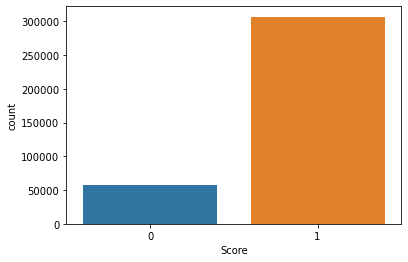

In [14]:
sns.countplot(data=final_data,x=final_data['Score'])

In [15]:
final_data.isnull().sum() #Data contains any null value or not 

Id                         0
ProductId                  0
UserId                     0
ProfileName               11
HelpfulnessNumerator       0
HelpfulnessDenominator     0
Score                      0
Time                       0
Summary                    1
Text                       0
dtype: int64

In [16]:
new_final=final_data.dropna()

In [17]:
new_final.isnull().all()

Id                        False
ProductId                 False
UserId                    False
ProfileName               False
HelpfulnessNumerator      False
HelpfulnessDenominator    False
Score                     False
Time                      False
Summary                   False
Text                      False
dtype: bool

## Text Preprocessing

The Preprocessing phase we do the following in the order below:-

1.Begin by removing the html tags.<br>
2.Remove any punctuations or limited set of special characters like , or . or # etc.<br>
3.Check if the word is made up of english letters and is not alpha-numeric.<br>
4.Check to see if the length of the word is greater than 2. (as it was researched that there is no adjective in 2-letters)<br>
5.Convert the word to lowercase.<br>
6.Remove Stopwords.<br>
7.Finally Snowball Stemming the word (it was obsereved to be better than Porter Stemming).<br>

After which we collect the words used to describe positive and negative reviews.<br>

In [18]:
# printing some random reviews
text_0=new_final['Text'].values[0]
print(text_0)
print("*"*120)
text_400=new_final['Text'].values[4]
text_1000=new_final['Text'].values[1000]
print(text_400)
print(120*"*")
print(text_1000)

this witty little book makes my son laugh at loud. i recite it in the car as we're driving along and he always can sing the refrain. he's learned about whales, India, drooping roses:  i love all the new words this book  introduces and the silliness of it all.  this is a classic book i am  willing to bet my son will STILL be able to recite from memory when he is  in college
************************************************************************************************************************
This is a book of poetry about the months of the year.  It goes through each month and has a cute little poem to go along with it.  I love this book because it is a really fun way to learn the months and the poems are very creative. The author's purpose for writing this book was to give children a fun way to learn the months.  The children can also learn things about poetry and rhythm through reading this book.
****************************************************************************************

In [19]:
df_text=new_final['Text']
df_text.shape

(364159,)

In [20]:
def decontracted(phrase):
    phrase = re.sub(r"won't", "will not", phrase)
    phrase = re.sub(r"can\'t", "can not", phrase)
    phrase = re.sub(r"n\'t", " not", phrase)
    phrase = re.sub(r"\'re", " are", phrase)
    phrase = re.sub(r"\'s", " is", phrase)
    phrase = re.sub(r"\'d", " would", phrase)
    phrase = re.sub(r"\'ll", " will", phrase)
    phrase = re.sub(r"\'t", " not", phrase)
    phrase = re.sub(r"\'ve", " have", phrase)
    phrase = re.sub(r"\'m", " am", phrase)
    return phrase

stopwords= set(['br', 'the', 'i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've",\
            "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', \
            'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their',\
            'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', \
            'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', \
            'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', \
            'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after',\
            'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further',\
            'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more',\
            'most', 'other', 'some', 'such', 'only', 'own', 'same', 'so', 'than', 'too', 'very', \
            's', 't', 'can', 'will', 'just', 'don', "don't", 'should', "should've", 'now', 'd', 'll', 'm', 'o', 're', \
            've', 'y', 'ain', 'aren', "aren't", 'couldn', "couldn't", 'didn', "didn't", 'doesn', "doesn't", 'hadn',\
            "hadn't", 'hasn', "hasn't", 'haven', "haven't", 'isn', "isn't", 'ma', 'mightn', "mightn't", 'mustn',\
            "mustn't", 'needn', "needn't", 'shan', "shan't", 'shouldn', "shouldn't", 'wasn', "wasn't", 'weren', "weren't", \
            'won', "won't", 'wouldn', "wouldn't"])

In [21]:
from bs4 import BeautifulSoup
from tqdm import tqdm
preprocessed_reviews = []
for sentance in tqdm(new_final['Text'].values):
    sentance = re.sub(r"http\S+", "", sentance)
    sentance = BeautifulSoup(sentance, 'lxml').get_text()
    sentance = decontracted(sentance)
    sentance = re.sub("\S*\d\S*", "", sentance).strip()
    sentance = re.sub('[^A-Za-z]+', ' ', sentance)
    # https://gist.github.com/sebleier/554280
    sentance = ' '.join(e.lower() for e in sentance.split() if e.lower() not in stopwords)
    preprocessed_reviews.append(sentance.strip())

100%|████████████████████████████████████████████████████████████████████████| 364159/364159 [05:02<00:00, 1203.05it/s]


In [22]:
preprocessed_reviews[0]

'witty little book makes son laugh loud recite car driving along always sing refrain learned whales india drooping roses love new words book introduces silliness classic book willing bet son still able recite memory college'

In [23]:
new_final['Text']=preprocessed_reviews
new_final=new_final[['Text','Score','Time']]
new_final=new_final.reset_index(drop=True)
new_final.to_csv('preprocessed_file.csv',index=False)

In [24]:
new_final=pd.read_csv('preprocessed_file.csv')
new_final.head()

,Text,Score,Time
0,witty little book makes son laugh loud recite ...,1,939340800
1,grew reading sendak books watching really rosi...,1,1194739200
2,fun way children learn months year learn poems...,1,1191456000
3,great little book read aloud nice rhythm well ...,1,1076025600
4,book poetry months year goes month cute little...,1,1018396800


In [25]:
new_final.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 364159 entries, 0 to 364158
Data columns (total 3 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   Text    363180 non-null  object
 1   Score   364159 non-null  int64 
 2   Time    364159 non-null  int64 
dtypes: int64(2), object(1)
memory usage: 8.3+ MB


In [26]:
new_final.isnull().all()

Text     False
Score    False
Time     False
dtype: bool

In [27]:
new_final['Time']=pd.to_datetime(new_final['Time'],unit='s')
new_final=new_final.sort_values('Time')
new_final=new_final.reset_index(drop=True)

In [28]:
new_final.head()

,Text,Score,Time
0,witty little book makes son laugh loud recite ...,1,1999-10-08
1,remember seeing show aired television years ag...,1,1999-10-25
2,beetlejuice well written movie everything exce...,1,1999-12-02
3,twist rumplestiskin captured film starring mic...,1,1999-12-06
4,beetlejuice excellent funny movie keaton hilar...,1,2000-01-03


In [29]:
new_final=new_final.sample(100000,random_state=42,replace=True)

In [30]:
from sklearn.model_selection import train_test_split
x=new_final["Text"]
y=new_final["Score"]
x_train,x_test,y_train,y_test=train_test_split(x,y,stratify=y,test_size=0.3,random_state=42)
print(x_train.shape,y_train.shape)
print(x_test.shape,y_test.shape)

(70000,) (70000,)
(30000,) (30000,)
